In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from imageio import imread
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")

In [38]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [39]:
def design_matrix(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)		# Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

In [40]:
def OLS_test_poly_degree(npoints, lower, upper, noise, sigma, scaling):

    np.random.seed(1)

    test_MSEs = []
    test_R2s = []
    train_MSEs = []
    train_R2s = []
    betas = []
    var_betas = []

    poly_order_range = range(lower, upper+1)

    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)


    x_gr, y_gr = np.meshgrid(x,y)

    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, sigma, (len(x),len(x)))

    for order in poly_order_range:

        X = design_matrix(x, y, order)

        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=1)
        if scaling == 1:

            X_train = X_train - np.mean(X_train, axis=0)
            X_test = X_test - np.mean(X_test, axis=0)
            z_train = z_train - np.mean(z_train, axis=0)
            z_test = z_test - np.mean(z_test, axis=0)

        beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        var_beta = sigma**2 * np.diag(np.linalg.pinv(X_train.T @ X_train))
        z_tilde = X_train @ beta
        z_pred = X_test @ beta

        test_MSEs.append(MSE(z_pred, z_test))
        train_MSEs.append(MSE(z_train,z_tilde))
        test_R2s.append(R2(z_test,z_pred))
        train_R2s.append(R2(z_train,z_tilde))
        betas.append(beta)
        var_betas.append(var_beta)

    return test_MSEs, test_R2s, train_MSEs, train_R2s, betas, var_betas

## No Scaling Test

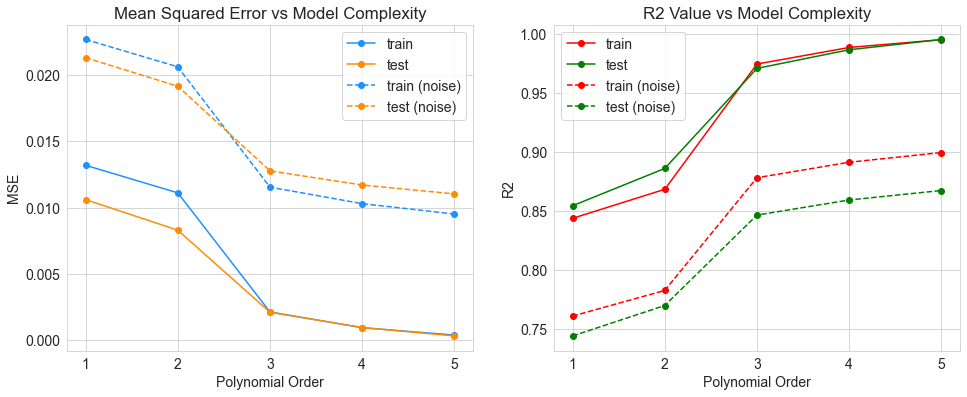

In [41]:
npoints = 100
lower_poly = 1
upper_poly = 5
poly_order_range = range(lower_poly, upper_poly+1)

test_MSEs, test_R2s, train_MSEs, train_R2s, betas, var_betas =  OLS_test_poly_degree(npoints, lower_poly,
                                                                upper_poly, noise=0, sigma=0, scaling=0)

N_test_MSEs, N_test_R2s, N_train_MSEs, N_train_R2s, N_betas, N_var_betas =  OLS_test_poly_degree(npoints, lower_poly,
                                                                            upper_poly, noise=1, sigma=0.1, scaling=0)

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].plot(poly_order_range, train_MSEs, '-o', color='dodgerblue', label='train')
ax[0].plot(poly_order_range, test_MSEs, '-o', color='darkorange', label='test')
ax[0].plot(poly_order_range, N_train_MSEs, '--o', color='dodgerblue', label='train (noise)')
ax[0].plot(poly_order_range, N_test_MSEs, '--o', color='darkorange', label='test (noise)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_xlabel('Polynomial Order')
ax[0].set_ylabel('MSE')
ax[0].set_title('Mean Squared Error vs Model Complexity')
ax[0].legend()
#ax[0,0].set_ylim(-0.001, 0.02)

ax[1].plot(poly_order_range, train_R2s, '-o', color='red', label='train')
ax[1].plot(poly_order_range, test_R2s, '-o', color='green', label='test')
ax[1].plot(poly_order_range, N_train_R2s, '--o', color='red', label='train (noise)')
ax[1].plot(poly_order_range, N_test_R2s, '--o', color='green', label='test (noise)')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_xlabel('Polynomial Order')
ax[1].set_ylabel('R2')
ax[1].set_title('R2 Value vs Model Complexity')
ax[1].legend()

## Scaling Test

In [42]:
npoints = 50
lower_poly = 1
upper_poly = 16
poly_order_range = range(lower_poly, upper_poly+1)

test_MSEs, test_R2s, train_MSEs, train_R2s, betas, var_betas =  OLS_test_poly_degree(npoints, lower_poly,
                                                                upper_poly, noise=0, sigma=0, scaling=1)

N_test_MSEs, N_test_R2s, N_train_MSEs, N_train_R2s, N_betas, N_var_betas =  OLS_test_poly_degree(npoints, lower_poly,
                                                                            upper_poly, noise=1, sigma=0.1, scaling=1)

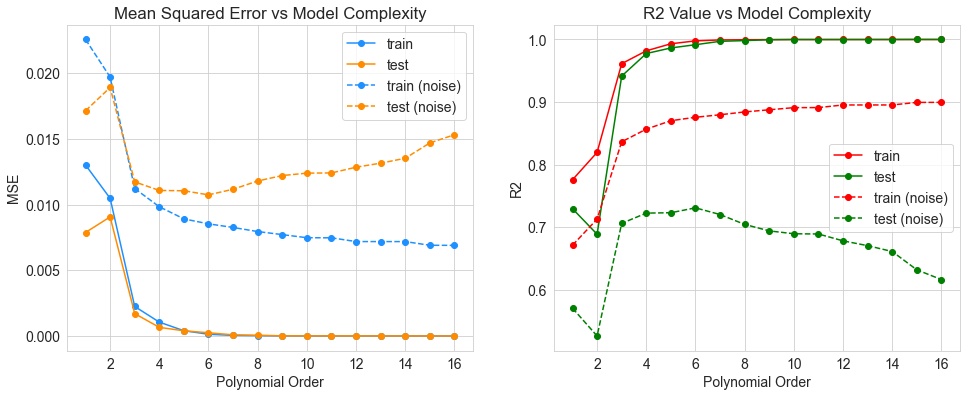

In [43]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].plot(poly_order_range, train_MSEs, '-o', color='dodgerblue', label='train')
ax[0].plot(poly_order_range, test_MSEs, '-o', color='darkorange', label='test')
ax[0].plot(poly_order_range, N_train_MSEs, '--o', color='dodgerblue', label='train (noise)')
ax[0].plot(poly_order_range, N_test_MSEs, '--o', color='darkorange', label='test (noise)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_xlabel('Polynomial Order')
ax[0].set_ylabel('MSE')
ax[0].set_title('Mean Squared Error vs Model Complexity')
ax[0].legend()
#ax[0,0].set_ylim(-0.001, 0.02)

ax[1].plot(poly_order_range, train_R2s, '-o', color='red', label='train')
ax[1].plot(poly_order_range, test_R2s, '-o', color='green', label='test')
ax[1].plot(poly_order_range, N_train_R2s, '--o', color='red', label='train (noise)')
ax[1].plot(poly_order_range, N_test_R2s, '--o', color='green', label='test (noise)')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_xlabel('Polynomial Order')
ax[1].set_ylabel('R2')
ax[1].set_title('R2 Value vs Model Complexity')
ax[1].legend()

## Beta Parameter Plotting

Text(0.5, 1.0, 'Beta Parameters for Different Polynomial Order Models')

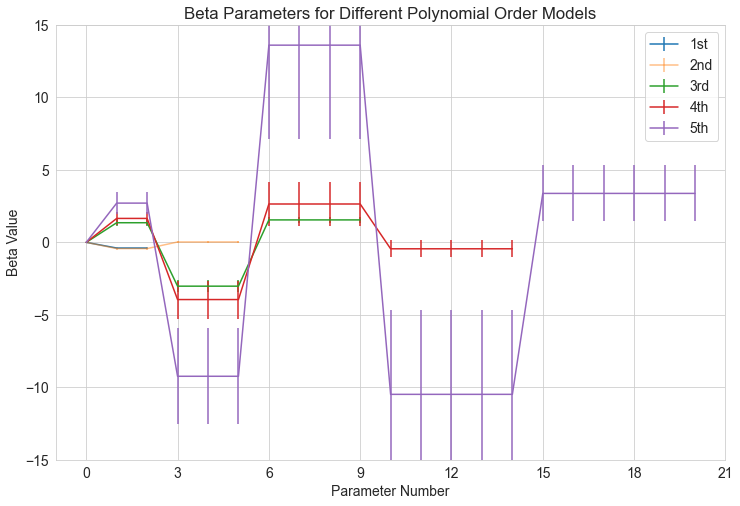

In [44]:
n = 20
fig,ax = plt.subplots(figsize=(12,8))

ax.errorbar(range(3), N_betas[0][:, n], yerr=np.sqrt(N_var_betas[0][:]),  label='1st')
ax.errorbar(range(6) ,N_betas[1][:, n], yerr=np.sqrt(N_var_betas[1][:]),  label='2nd', alpha=0.5)
ax.errorbar(range(10),N_betas[2][:, n], yerr=np.sqrt(N_var_betas[2][:]),  label='3rd')
ax.errorbar(range(15),N_betas[3][:, n], yerr=np.sqrt(N_var_betas[3][:]), label='4th')
ax.errorbar(range(21),N_betas[4][:, n], yerr=np.sqrt(N_var_betas[4][:]),  label='5th')

# ax.plot(betas[0][:, n], '-o', label='1st')
# ax.plot(betas[1][:, n], '-o', label='2nd', alpha=0.5)
# ax.plot(betas[2][:, n], '-o', label='3rd')
# ax.plot(betas[3][:, n], '-o', label='4th')
# ax.plot(betas[4][:, n], '-o', label='5th')
ax.set_ylim(-15, 15)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
ax.set_xlabel('Parameter Number')
ax.set_ylabel('Beta Value')
ax.set_title('Beta Parameters for Different Polynomial Order Models')

In [45]:
N_var_betas[0][:]

array([0.        , 0.00077401, 0.00077401])

## Bootstrap and Bias Variance

In [ ]:
def OLS_test_bootstrap(npoints, lower, upper, noise, sigma, scaling, nbootstraps):

    np.random.seed(5)
    errors = []
    biases = []
    variances = []
    poly_order_range = range(lower, upper+1)

    n_bootstraps = nbootstraps

    x = np.linspace(0, 1, npoints)

    y = np.linspace(0, 1, npoints)
    x_gr, y_gr = np.meshgrid(x,y)

    if noise==1:
        z = FrankeFunction(x_gr, y_gr) + np.random.normal(0, sigma, (len(x),len(x)))
    else:
        z = FrankeFunction(x_gr, y_gr)


    for order in poly_order_range:

        X = design_matrix(x, y, order)

        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        z_test = np.expand_dims(z_test, 2)
        features = int((order+1)*(order+2)/2)

        z_pred = np.empty((z_test.shape[0], npoints, n_bootstraps))



        for i in range(n_bootstraps):
            X_train_, z_train_ = resample(X_train, z_train)

            beta = np.linalg.pinv(X_train_.T @ X_train_) @ X_train_.T @ z_train_

            ztilde = X_train_ @ beta

            z_pred[:, :, i] = X_test @ beta

        error = np.mean( np.mean((z_test - z_pred)**2, axis=2) )
        bias = np.mean( (z_test - np.mean(z_pred, axis=2, keepdims=True))**2 )
        variance = np.mean( np.var(z_pred, axis=2, keepdims=True) )

        errors.append(error)
        biases.append(bias)
        variances.append(variance)

    return errors, biases, variances

In [47]:
npoints = 30
lower_poly = 1
upper_poly = 10
poly_order_range = range(lower_poly, upper_poly+1)
nbootstraps = 100
noise = 1
sigma = 0.01
scaling = 1

errors, biases, variances = OLS_test_bootstrap(npoints, lower_poly, upper_poly, noise, sigma, scaling, nbootstraps)

Text(0.5, 1.0, 'Bias Variance Tradeoff Demonstrated for OLS')

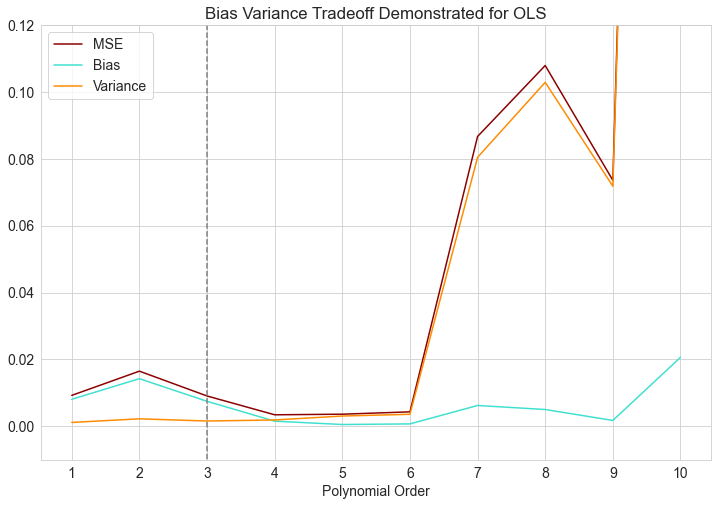

In [48]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(poly_order_range, errors, color='darkred', label='MSE')
ax.plot(poly_order_range, biases, color='turquoise', label='Bias')
ax.plot(poly_order_range, variances, color='darkorange', label='Variance')
ax.vlines(3, -1, 1, color='grey', linestyles='--')
ax.set_ylim(-0.01, 0.12)
ax.legend()
ax.set_xlabel('Polynomial Order')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Bias Variance Tradeoff Demonstrated for OLS')
#fig.savefig('bias_variance_OLS.jpg', dpi=1000, bbox_inches='tight')

## Cross Validation

In [ ]:
def OLS_CV(npoints, lower, upper, noise, sigma, nfolds, scaling):

    np.random.seed(7)

    poly_order_range = range(lower, upper+1)
    k = nfolds
    kfold = KFold(n_splits = k)
    scores_KFold = np.zeros((len(poly_order_range), k))

    x = np.linspace(0, 1, npoints)

    y = np.linspace(0, 1, npoints)


    if scaling == 1:
        x = (x-x.mean()) / x.std()
        y = (y-y.mean()) / y.std()

    x_gr, y_gr = np.meshgrid(x,y)

    if noise==1:
        z = FrankeFunction(x_gr, y_gr) + np.random.normal(0, 0.01, (len(x),len(x)))
    else:
        z = FrankeFunction(x_gr, y_gr)

    i = 0
    for order in poly_order_range:

        X = design_matrix(x, y, order)
        j = 0
        for train_inds, test_inds in kfold.split(X):
            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]
            if scaling == 1:

                X_train = X_train - np.mean(X_train, axis=0)
                X_test = X_test - np.mean(X_test, axis=0)
                z_train = z_train - np.mean(z_train, axis=0)
                z_test = z_test - np.mean(z_test, axis=0)

            beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
            ztilde = X_train @ beta
            z_pred = X_test @ beta

            scores_KFold[i,j] = MSE(z_pred, z_test)

            j += 1
        i += 1


    estimated_mse_KFold = np.mean(scores_KFold, axis = 1)


    return estimated_mse_KFold

In [50]:
npoints = 100
lower_poly = 1
upper_poly = 6
poly_order_range = range(lower_poly, upper_poly+1)
noise = 1
sigma = 0.1
mse_cvs = []
for nfolds in range(5, 11):

    mse_cv = OLS_CV(npoints, lower_poly, upper_poly, noise, sigma, nfolds, scaling=1)
    mse_cvs.append(mse_cv)

Text(0.5, 1.0, 'Cross Validation-estimated MSE for OLS')

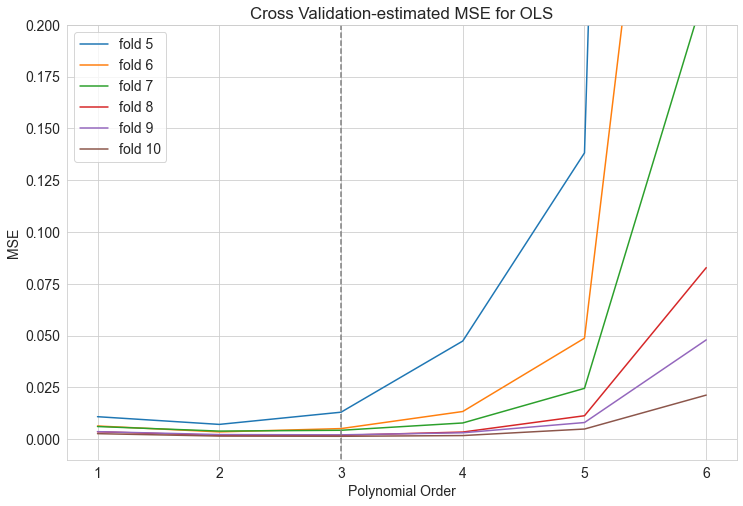

In [51]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(poly_order_range, mse_cvs[0], label='fold 5')
ax.plot(poly_order_range, mse_cvs[1], label='fold 6')
ax.plot(poly_order_range, mse_cvs[2], label='fold 7')
ax.plot(poly_order_range, mse_cvs[3], label='fold 8')
ax.plot(poly_order_range, mse_cvs[4], label='fold 9')
ax.plot(poly_order_range, mse_cvs[5], label='fold 10')
ax.legend()
ax.vlines(3, -1, 1, color='grey', linestyles='--')
ax.set_ylim(-0.01, 0.2)
ax.set_xlabel('Polynomial Order')
ax.set_ylabel('MSE')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Cross Validation-estimated MSE for OLS')
#fig.savefig('Cross_validation_OLS.jpg', dpi=1000, bbox_inches='tight')